In [146]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [191]:
%matplotlib inline

import itertools
#from sessions import selected_009266, selected_008229, selected_009265, selected_57, selected_013829
from sessions_nMAP_EV_SU import selected
from imports import *
from scipy import stats
from scipy import signal
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from itertools import combinations
from scipy.stats import ttest_rel
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [192]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [193]:
def pval2text(p_val):
    if p_val > 0.05:
        return 'n.s.'
    elif p_val > 0.01:
        return '*'
    elif p_val > 0.001:
        return '**'
    elif p_val > 0.0001:
        return '***'
    else:
        return '****'

In [194]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

all_selected = []
for animal, s_list in selected.items():
    all_selected += s_list

all_selected[:7], len(all_selected)

(['009266_hippoSIT_2023-04-17_17-04-17',
  '009266_hippoSIT_2023-04-18_10-10-37',
  '009266_hippoSIT_2023-04-18_17-03-10',
  '009266_hippoSIT_2023-04-19_10-33-51',
  '009266_hippoSIT_2023-04-20_08-57-39',
  '009266_hippoSIT_2023-04-21_08-43-00',
  '009266_hippoSIT_2023-04-21_13-12-31'],
 65)

In [195]:
to_exclude = [
    '009265_hippoSIT_2023-03-03_16-00-47',  # due to behavior
]
all_selected = [x for x in all_selected if not x in to_exclude]

## Collecting data

In [177]:
animals = list(set([session.split('_')[0] for session in all_selected]))
animals

['57', '009266', '009265', '013829']

In [181]:
# use a diff order
animals = ['57', '013829', '009265', '009266']

In [280]:
speed_thresh = 0.04  # m/s

means = []
engagement = []

for k, session in enumerate(all_selected):
#for k, session in enumerate(selected['009265']):
    
    animal   = session.split('_')[0]
    session_path = os.path.join(source, animal, session)
    #nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_noconv.h5')
    nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_with_PSTH.h5')
    bmap_file  = os.path.join(session_path, 'analysis', 'bMAP_segmentation.h5')
    meta_file  = os.path.join(session_path, 'meta.h5')
    #mose_file  = os.path.join(session_path, 'MoSeq.h5')
    mose_file  = os.path.join(session_path, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    desc_file  = os.path.join(session_path, 'descendants.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        trials = np.array(f['processed']['trial_idxs'])
    with h5py.File(nmap_file, 'r') as f:
        fit = np.array(f['response_manifold'])
        unit_mx_ev = np.array(f['unit_mx_proc_ev'])
        unit_mx_su = np.array(f['unit_mx_proc_su'])
#     with h5py.File(mose_file, 'r') as f:
#         moseq = np.array(f['moseq'])
#         headers = list(f['moseq'].attrs['headers'])
    
    with h5py.File(mose_file, 'r') as f:
        syl_ratio_mx = np.array(f['syl_ratio_mx'])
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
    
    #if os.path.exists(desc_file):
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    speed_ev = speed[sound_events[:, 2].astype(np.int32)]

    with h5py.File(bmap_file, 'r') as f:
        idxs_bE_ev = np.array(f['idxs_tgt_succ_state_ev'])
    idxs_bU_ev = np.array([x for x in range(len(sound_events)) if not x in idxs_bE_ev])
    engaged_ev = np.zeros(len(sound_events))  # just engaged state 0/1, event sampling
    engaged_ev[idxs_bE_ev] = 1

    unit_count = unit_mx_ev.shape[1]
    
    # "performance"
    tr_succ = trials[trials[:, 5] == 1]
    performance = len(tr_succ) / (len(trials))
    
    idxs_suc_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_suc_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_suc_ev = np.array(idxs_suc_ev)

    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed_ev < speed_thresh)[0]  # define speed filter here
    idxs_run_ev = np.where(speed_ev > speed_thresh)[0]
    idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
    #idxs_noi_ev = np.where(sound_events[:, 1] == -1)[0]
    #idxs_non_ev = np.where( (sound_events[:, 1] == 0) | (sound_events[:, 1] == 1) )[0]  # non-target

    # for behavioral state
    #idxs_non_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_non_ev)
    #idxs_non_sta_bE_ev = np.intersect1d(idxs_bE_ev, idxs_non_sta_ev)
    #idxs_non_sta_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_sta_ev)
    #idxs_sil_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_sil_ev)

    # for speed
    #idxs_non_run_ev    = np.intersect1d(idxs_run_ev, idxs_non_ev)
    #idxs_non_run_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_run_ev)
    #idxs_sil_bU_ev     = np.intersect1d(idxs_bU_ev, idxs_sil_ev)

    curr_mean = syl_ratio_mx.mean(axis=0)
    means.append([animals.index(animal), 0, performance] + list(syl_ratio_mx[idxs_sil_ev].mean(axis=0) / curr_mean))
    means.append([animals.index(animal), 1, performance] + list(syl_ratio_mx[idxs_bgr_ev].mean(axis=0) / curr_mean))
    #means.append([animals.index(animal), 2] + list(syl_ratio_mx[idxs_tgt_ev].mean(axis=0) / curr_mean))
    means.append([animals.index(animal), 2, performance] + list(syl_ratio_mx[idxs_suc_ev].mean(axis=0) / curr_mean))

    # proportion engaged
    pulse_count = float(len(sound_events))
    engagement.append([animals.index(animal), 0, 
       len(np.intersect1d(idxs_sil_ev, idxs_bE_ev))/pulse_count, 
       len(np.intersect1d(idxs_sil_ev, idxs_bU_ev))/pulse_count,
       len(np.intersect1d(idxs_sil_ev, idxs_run_ev))/pulse_count,
       len(np.intersect1d(idxs_sil_ev, idxs_sta_ev))/pulse_count
    ])
    engagement.append([animals.index(animal), 1, 
        len(np.intersect1d(idxs_bgr_ev, idxs_bE_ev))/pulse_count,
        len(np.intersect1d(idxs_bgr_ev, idxs_bU_ev))/pulse_count,
        len(np.intersect1d(idxs_bgr_ev, idxs_run_ev))/pulse_count,
        len(np.intersect1d(idxs_bgr_ev, idxs_sta_ev))/pulse_count,
    ])
    engagement.append([animals.index(animal), 2, 
        len(np.intersect1d(idxs_suc_ev, idxs_bE_ev))/pulse_count,
        len(np.intersect1d(idxs_suc_ev, idxs_bU_ev))/pulse_count,
        len(np.intersect1d(idxs_suc_ev, idxs_run_ev))/pulse_count,
        len(np.intersect1d(idxs_suc_ev, idxs_sta_ev))/pulse_count,
    ])
    
    print(f"Session {session} completed ({k} from {len(all_selected)})\r", end='')
    
    
# animal ID, sound_type, performance, S1, S2, S3, ..., S10
means = np.array(means)
engagement = np.array(engagement)

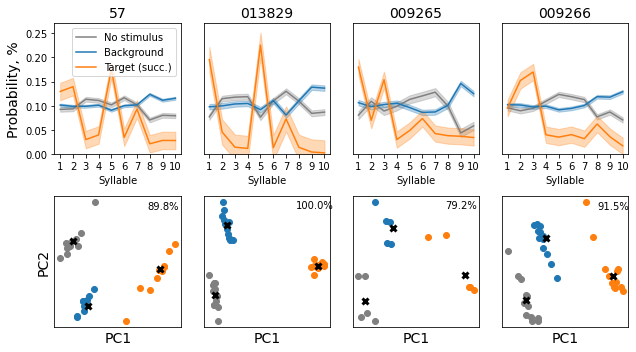

In [249]:
fig, axes = plt.subplots(2, 4, figsize=(9, 5))

colors = ['grey', 'tab:blue', 'tab:orange']
labels = ['No stimulus', 'Background', 'Target (succ.)']

for i in range(len(animals)):  # animal
    profiles_a = means[(means[:, 0] == i) & (means[:, 2] > 0.6)]  # filter animal / performance
    syll_x_vals = range(1, len(profiles_a.T[3:])+1)
    
    ax = axes[0][i]
    for j in range(3):  # sound
        profiles_a_s = profiles_a[(profiles_a[:, 1] == j)][:, 3:]
        
        # plot all means
        #for mean in profiles_a_s:
        #    ax.plot(mean, color=colors[j])
        m = profiles_a_s.mean(axis=0) / len(profiles_a_s.T)
        sem = stats.sem(m, axis=0)
        #sem = np.std(m, axis=0)
        
        ax.plot(syll_x_vals, m, color=colors[j], label=labels[j])
        ax.fill_between(syll_x_vals, m - sem, m + sem, color=colors[j], alpha=0.3)
    ax.set_ylim(0, 0.27)
    ax.set_title(animals[i], fontsize=14)
    if i > 0:
        ax.set_yticks([])
    else:
        ax.set_ylabel('Probability, %', fontsize=14)
        ax.legend()
    ax.set_xticks(syll_x_vals)
    ax.set_xlabel('Syllable')
    
    
    # plot PCA and k-means
    pca = decomposition.PCA(n_components=2)
    X = pca.fit_transform(profiles_a)

    kmeans = KMeans(n_clusters=3, random_state=7)
    kmeans.fit(X)
    pred_score = adjusted_rand_score(profiles_a[:, 1], kmeans.labels_)  # from 0 to 1
    
    ax = axes[1][i]
    for j in range(3):  # sound
        idxs_t = np.where(profiles_a[:, 1] == j)[0]
        ax.scatter(X[idxs_t][:, 0], X[idxs_t][:, 1], color=colors[j])
    
    # k-means
    #ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    ax.text(0.6 * X[:, 0].max(), 0.9 * X[:, 1].max(), f"{100*pred_score:.1f}%")
    centroids = kmeans.cluster_centers_
    ax.scatter(centroids[:, 0], centroids[:, 1], marker="x", linewidths=3, color="black", zorder=10)

    ax.set_xlabel('PC1', fontsize=14)
    if i == 0:
        ax.set_ylabel('PC2', fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
        
fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'behav_profiles_SIL_BGR_TGT-PCA.png'), dpi=300)

## Engagement

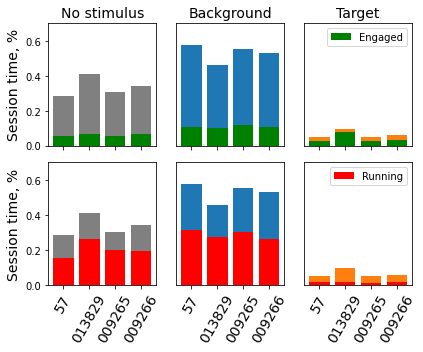

In [283]:
fig, axes = plt.subplots(2, 3, figsize=(6, 5))

colors = ['grey', 'tab:blue', 'tab:orange']
titles = ['No stimulus', 'Background', 'Target']

for i in range(3):  # sound types
    x_vals = [x for x in range(len(animals))]
    y_vals_e, y_vals_u = [], []  # engaged, undetermined
    y_vals_r, y_vals_s = [], []  # running, stationary
    for animal_id in range(len(animals)):
        data_filt = engagement[(engagement[:, 0] == animal_id) & (engagement[:, 1] == i)]
        y_vals_e.append(data_filt[:, 2].mean())
        y_vals_u.append(data_filt[:, 3].mean())
        y_vals_r.append(data_filt[:, 4].mean())
        y_vals_s.append(data_filt[:, 5].mean())
        
    # engaged / undetermined
    ax = axes[0][i]
    ax.bar(x_vals, y_vals_e, color='green', label='Engaged')
    ax.bar(x_vals, y_vals_u, bottom=y_vals_e, color=colors[i])
    ax.set_ylim(0, 0.7)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xticks(x_vals)
    ax.set_xticklabels([])
    if i == 2:
        ax.legend(loc='upper right')
    if i > 0:
        ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Session time, %', fontsize=14)

    # running / stationary
    ax = axes[1][i]
    ax.bar(x_vals, y_vals_r, color='red', label='Running')
    ax.bar(x_vals, y_vals_s, bottom=y_vals_r, color=colors[i])
    ax.set_ylim(0, 0.7)
    #ax.set_title(titles[i], fontsize=14)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(animals, rotation=60, fontsize=14)
    if i == 2:
        ax.legend(loc='upper right')
    if i > 0:
        ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Session time, %', fontsize=14)
        
fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'bE-bU_run-sta_cross-animal_stats.png'), dpi=300)

In [253]:
engagement = np.array(engagement)

In [257]:
data_filt

array([], shape=(0, 4), dtype=float64)

In [262]:
engagement[:, 0] == 2

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,